#  `Oil | Water` Production Prediction within the Volve Oil Field

In this notebook we attempt to predict the oil and water production using the published volve production dataset.
<br>
The sequence is as follow:
- Data filtering, cleaning and EDA
- Apply linear regression via squared error loss and Huber loss

In [272]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
import missingno as ms

## Data filtering, cleaning and EDA

In [273]:
# loading the data
df = pd.read_excel("Volve production data.xlsx",parse_dates=True)

In [274]:
# all wells in the dataset
df["WELL_BORE_CODE"].unique()

array(['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H',
       'NO 15/9-F-14 H', 'NO 15/9-F-15 D', 'NO 15/9-F-4 AH',
       'NO 15/9-F-5 AH'], dtype=object)

In [275]:
# filter for only one well
df = df[df["WELL_BORE_CODE"] == 'NO 15/9-F-14 H']

In [276]:
# have a quick look at the data distribution
df.describe()

,DATEPRD,NPD_WELL_BORE_CODE,NPD_FIELD_CODE,NPD_FACILITY_CODE,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL
count,3056,3056.0,3056.0,3056.0,3056.000000,3050.000000,3050.000000,3050.000000,2533.000000,2860.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,0.0
mean,2012-06-04 14:32:40.209423872,5351.0,3420717.0,369304.0,20.541124,233.074650,95.133792,192.653083,10.527984,69.390287,41.530600,77.103031,15.435757,1289.997837,189139.248043,2330.251878,NaN
min,2008-02-12 00:00:00,5351.0,3420717.0,369304.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-59.190000,NaN
25%,2010-03-24 18:00:00,5351.0,3420717.0,369304.0,24.000000,237.493045,99.620673,180.749433,0.000000,43.014155,31.020474,81.223317,2.665658,209.862500,31304.035000,695.592500,NaN
50%,2012-06-10 12:00:00,5351.0,3420717.0,369304.0,24.000000,246.776063,101.007540,204.247625,12.968633,71.012952,33.545751,86.963304,7.177533,880.785000,142362.865000,2965.715000,NaN
75%,2014-08-15 06:00:00,5351.0,3420717.0,369304.0,24.000000,261.970976,105.049314,229.632848,21.231843,100.000000,49.080514,88.538931,21.173839,2033.697500,305327.862500,3444.147500,NaN
max,2016-09-17 00:00:00,5351.0,3420717.0,369304.0,25.000000,334.656140,106.772733,302.109760,26.682243,100.000000,125.718570,93.509584,125.718570,5644.370000,789974.730000,5691.770000,NaN
std,NaN,0.0,0.0,0.0,7.881214,64.923764,25.846815,57.736985,9.704604,31.064575,22.719568,25.615703,19.965154,1298.358922,184204.114106,1462.934595,NaN


Oil production typically decreases as water production increases.

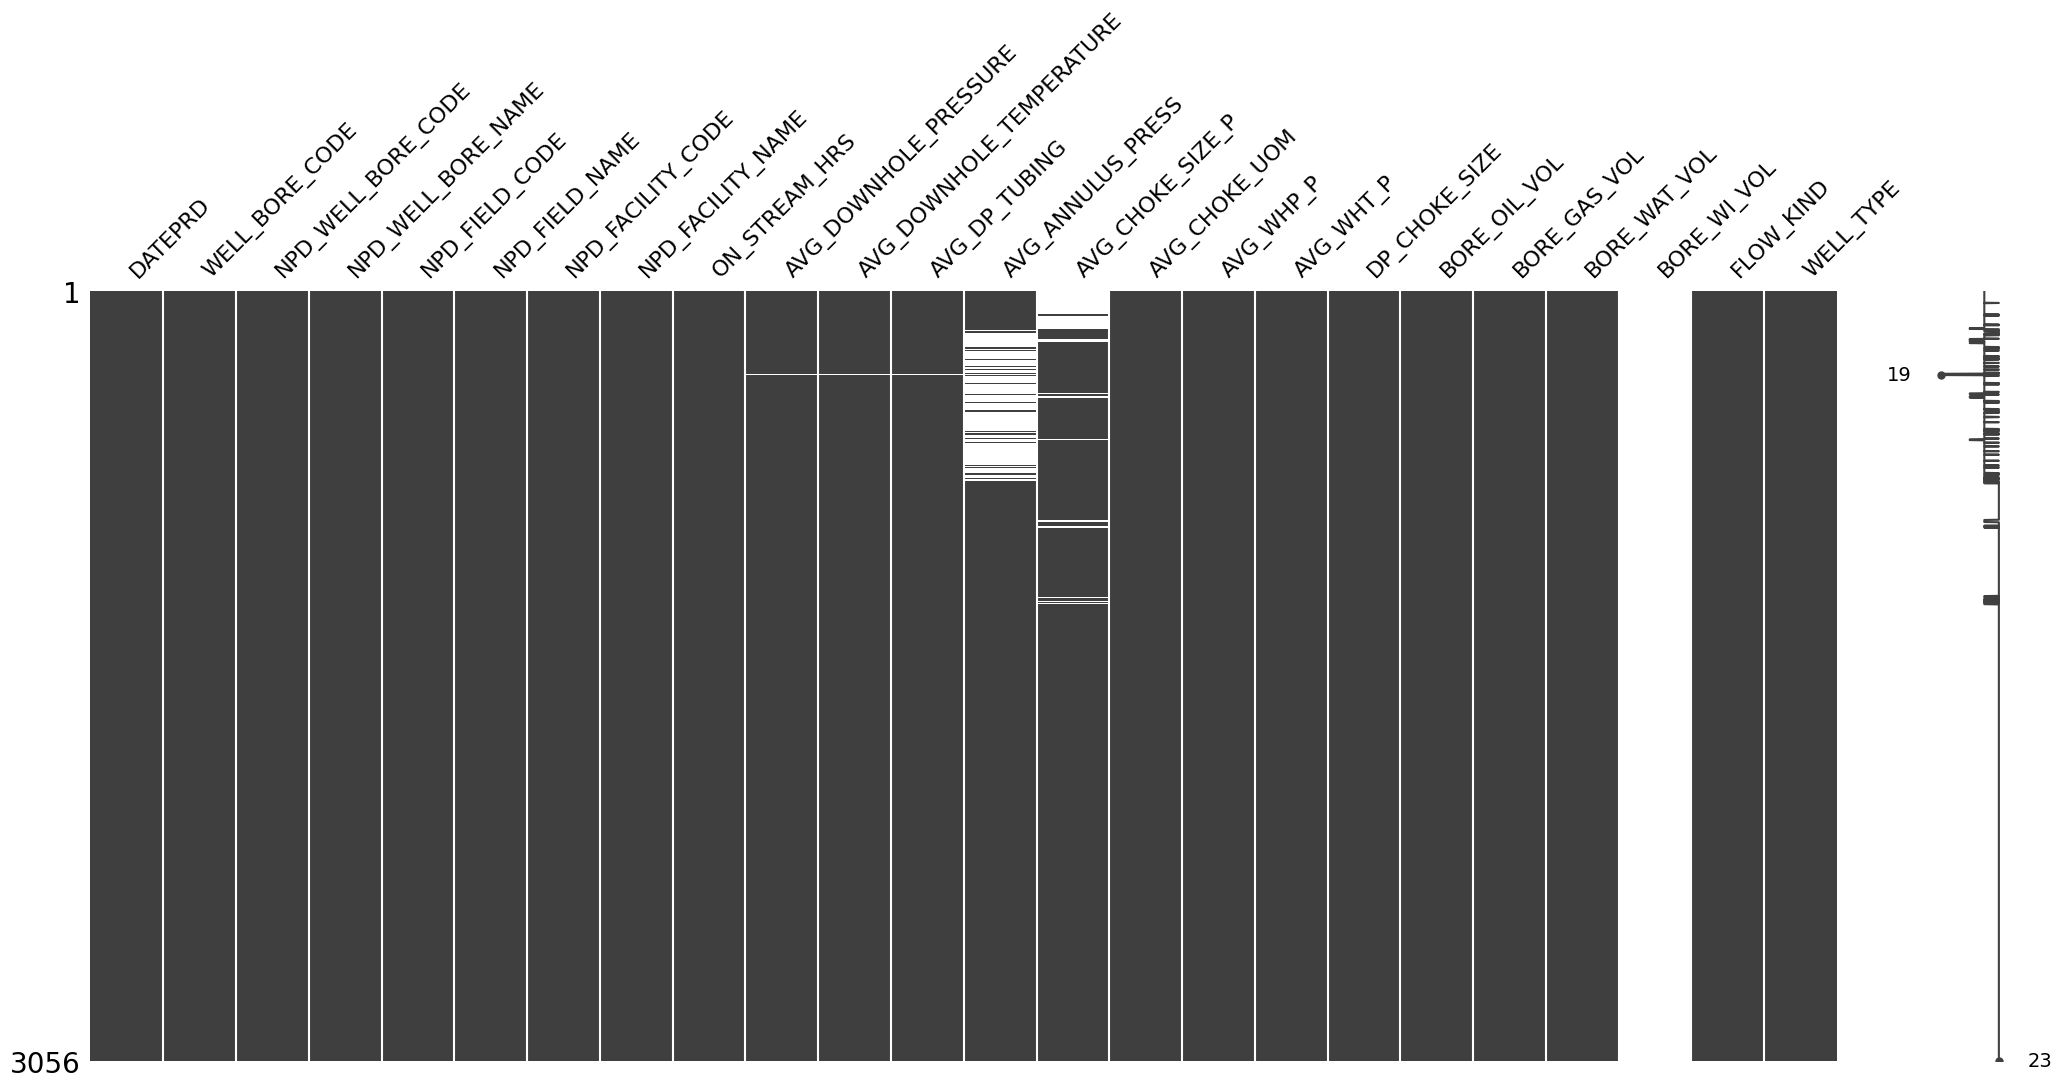

In [278]:
# have a look at the missing valeus in the data 
ms.matrix(df);

In [279]:
# let us drop missing values
df= df[
    ['DATEPRD','ON_STREAM_HRS','AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','AVG_DP_TUBING'
     ,'AVG_WHP_P','AVG_WHT_P','DP_CHOKE_SIZE','BORE_OIL_VOL', 'BORE_WAT_VOL']
].dropna()

In [280]:
# convert oil and water volumes into rates per hour
df = df[df["ON_STREAM_HRS"] > 0] # to remove rows that represents no procution
df["oil_rate"] = (df["BORE_OIL_VOL"] / df["ON_STREAM_HRS"]) # get the oil produciton rate
df["water_rate"] = (df["BORE_WAT_VOL"] / df["ON_STREAM_HRS"]) # get the oil produciton rate
df.drop(columns=["ON_STREAM_HRS"],inplace=True) # remove the hours of procution as we don't need it any more

In [281]:
# drop the oil_volume and water volume also
df.drop(columns=["BORE_OIL_VOL","BORE_WAT_VOL"],inplace=True)

#### We can spot many outliers in the data, including negative values for water production rate. We cutoff the dataset at about the half-life of the well which seems to have happened at around 2012.

In [283]:
# we take the data to be only of the until 2012
df = df[df["DATEPRD"] < "2012"]

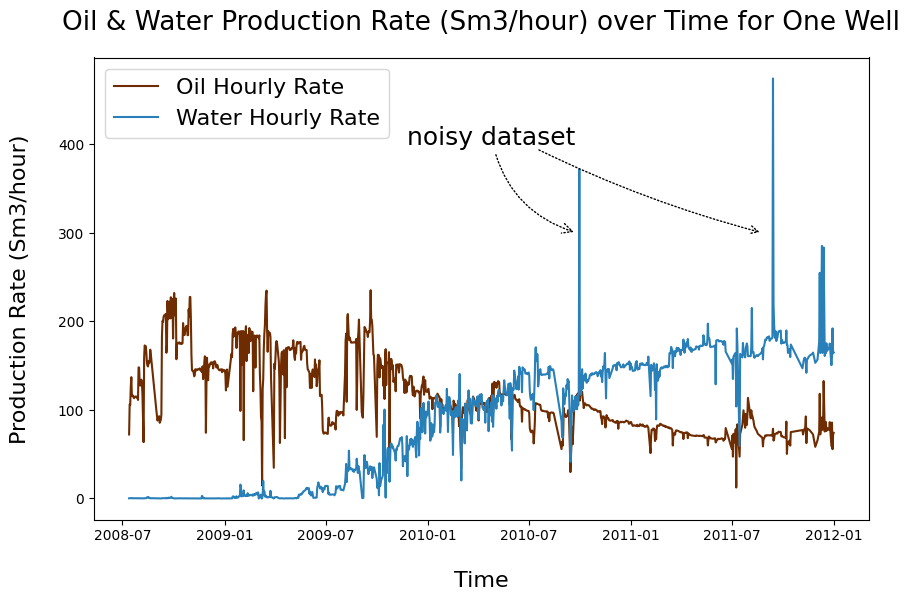

In [285]:


# main figure object
fig, ax = plt.subplots(figsize=(10,6)) 
#plt.figure(figsize= (10,5))
# make scatter plot between oil and gas production
plt.plot( df["DATEPRD"], df["oil_rate"],color="#6E2C00",label="Oil Hourly Rate") 
plt.plot(df["DATEPRD"],df["water_rate"],color="#2980B9",label="Water Hourly Rate");

# setting axes (x and y) labels 
plt.xlabel("Time", fontsize= 16, labelpad = 20,)
plt.ylabel("Production Rate (Sm3/hour)", fontsize= 16, labelpad = 20,loc="center")

# setting figure title 
plt.title("Oil & Water Production Rate (Sm3/hour) over Time for One Well", fontsize= 19, pad = 20,loc="center")

# grid 
plt.legend(fontsize=16);

ax.annotate('noisy dataset', xy=(np.datetime64('2010-09-25'), 300), xytext=(np.datetime64('2009-11-25'), 400),
            arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=0.3', 'linestyle':'dotted'}, fontsize=18)

ax.annotate('', xy=(np.datetime64('2011-08-25'), 300), xytext=(np.datetime64('2010-07-15'), 395),
            arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=0.05', 'linestyle':'dotted'}, fontsize=14)


fig.savefig(\
        "../../Explainer/images/oil_production.png",\
            bbox_inches='tight')

#### Let us perform some rudimentary EDA

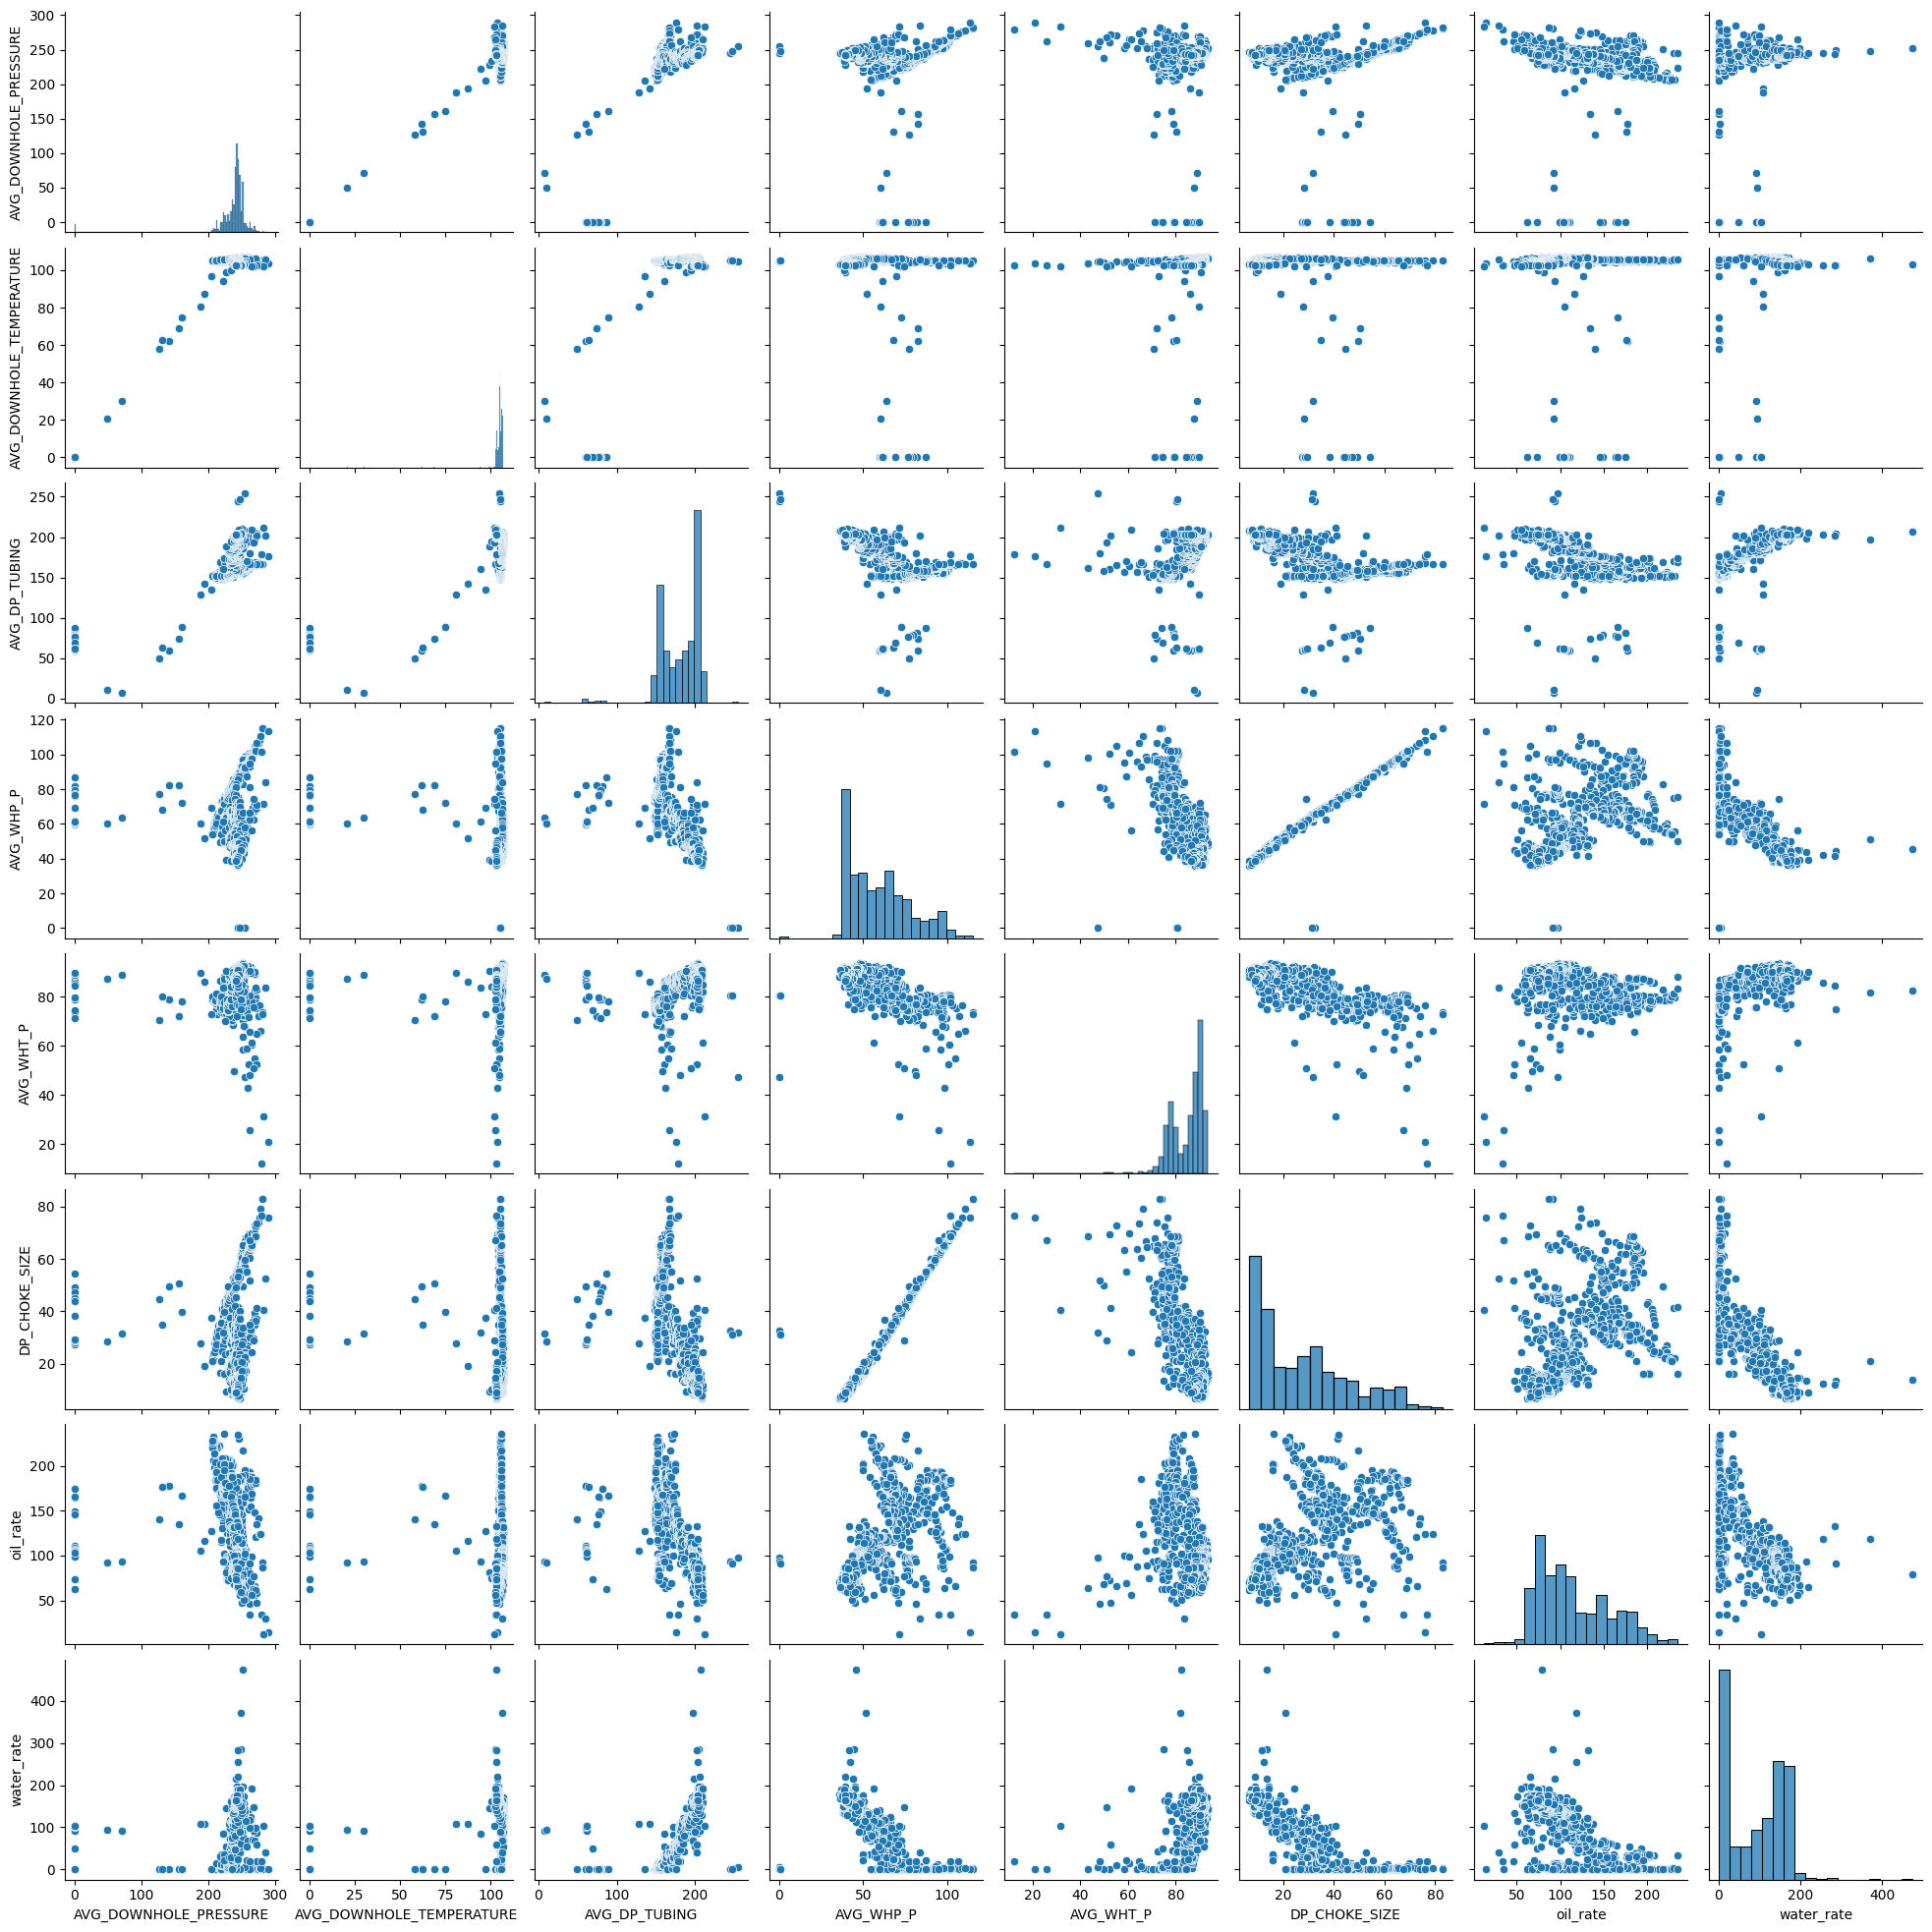

In [286]:
# have a look at all the scatter plots between all variables
sns.pairplot(df);

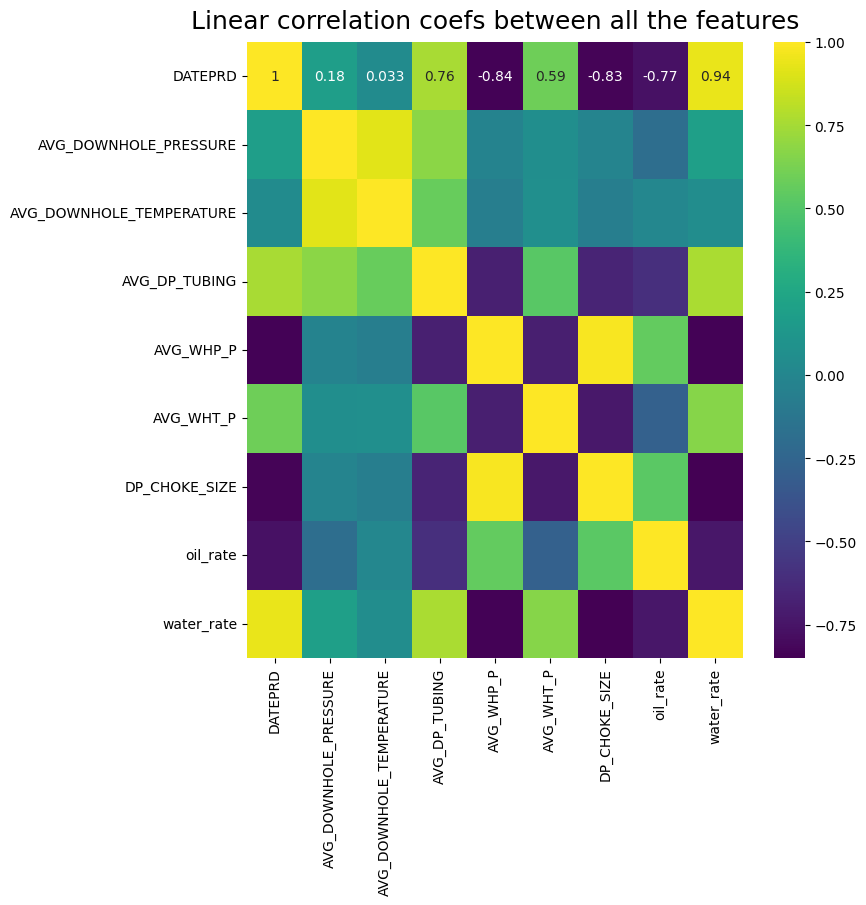

In [287]:
# show the pearson correlation coef between all the variables, show the linear correlation
plt.figure(figsize=(8,8))
plt.title("Linear correlation coefs between all the features",fontsize=18,pad=10)
sns.heatmap(df.corr(), annot=True, cmap="viridis");

In [480]:
# remove the zeros form the columns
df = df[df!=0]
df = df[ df.AVG_WHP_P >0]
# remove the water spikes
df = df[df.water_rate < 300]
#remove as i think anomoly data in the average tuping losses 
df = df[df["AVG_DP_TUBING"] > 100]
df = df[ df["AVG_WHP_P"] >10 ]

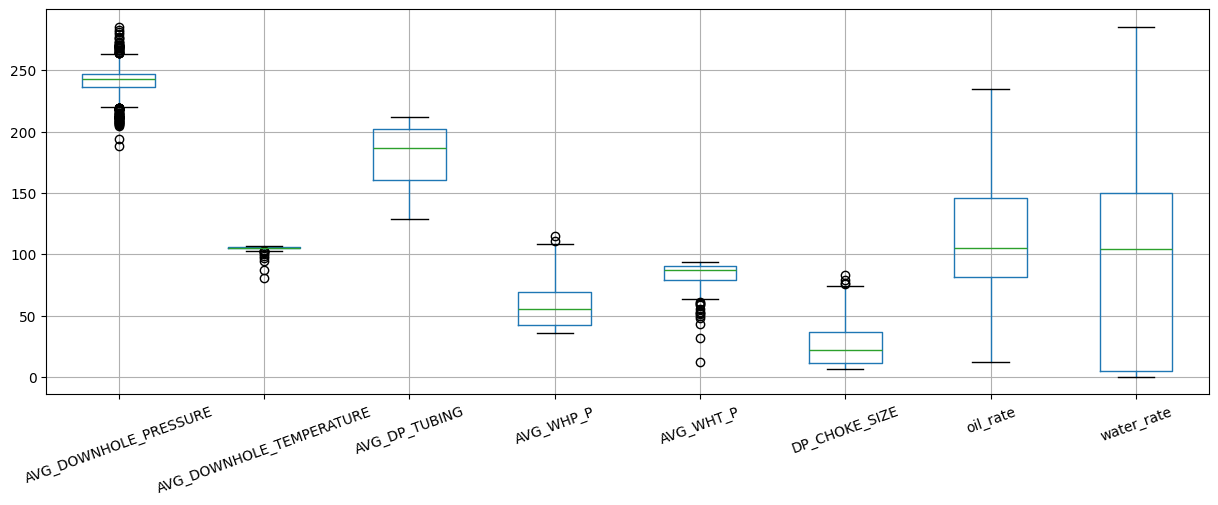

In [491]:
plt.figure(figsize=(15,5))
(df.drop("days",axis=1)).boxplot()
plt.xticks(rotation=20);

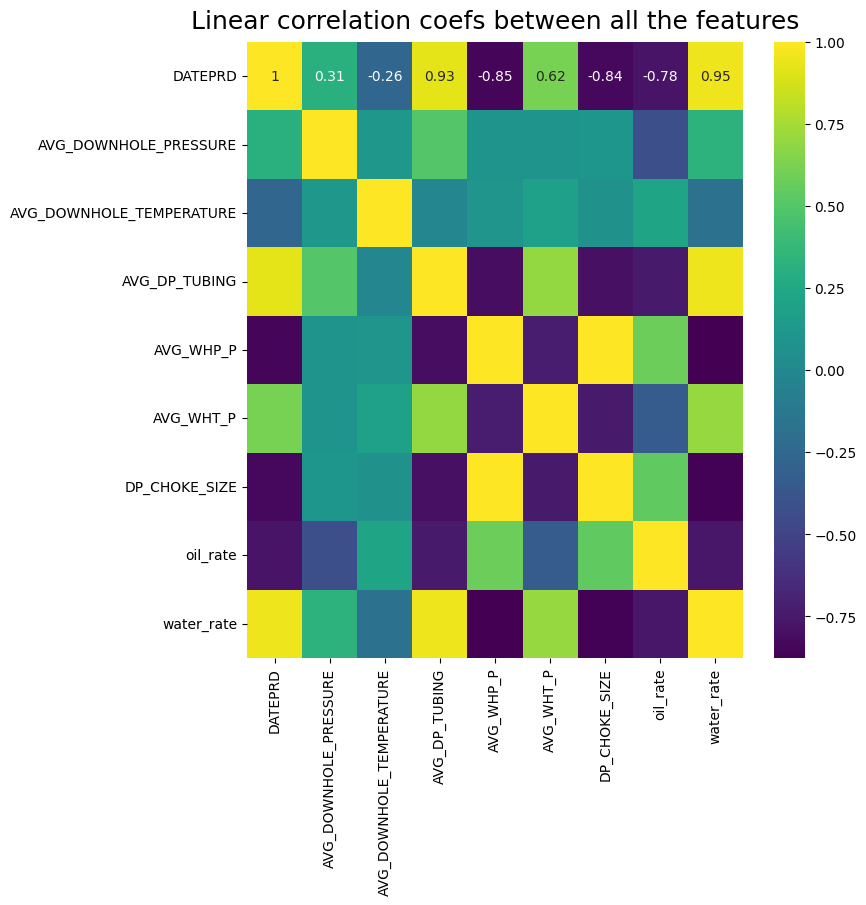

In [291]:
# show the pearson correlation coef between all the variables, show the linear correlation
plt.figure(figsize=(8,8))
plt.title("Linear correlation coefs between all the features",fontsize=18,pad=10)
sns.heatmap(df.corr(), annot=True, cmap="viridis");

#### There seems to be a large linear coef between oil rate and the features

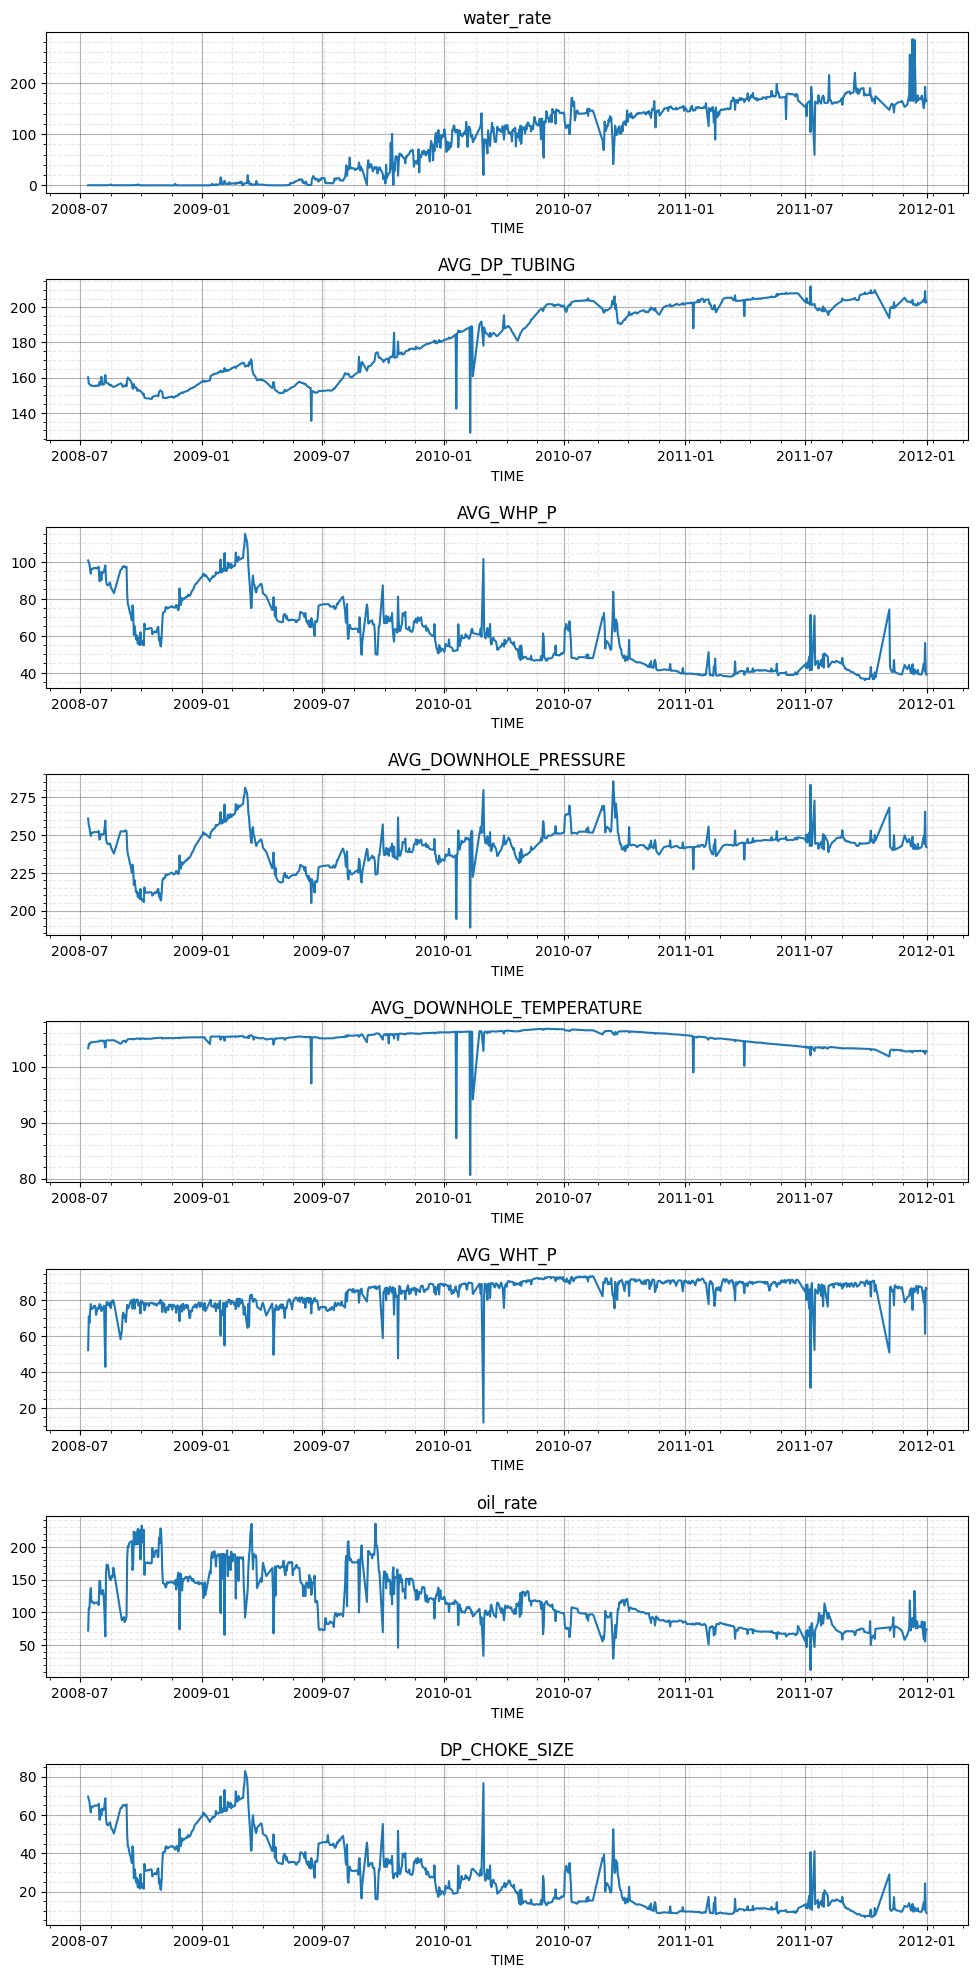

In [292]:
# lets see the variation in the features with time 
plt.figure(figsize= (10,20))
cols = set(list(df.columns)) - set(["DATEPRD"])

for i, col in enumerate(cols) :
    plt.subplot(len(cols),1,i+1)
    # make scatter plot between oil and gas production
    plt.plot( df["DATEPRD"], df[col]) 

    # setting axes (x and y) labels 
    plt.xlabel("TIME" )
    plt.title(col)
    # grid 
    plt.grid( which="major", linestyle="-", alpha=.5, color="#6666")
    plt.minorticks_on()
    plt.grid( which="minor", linestyle="--", alpha=.2, color="#9999")
    
plt.tight_layout(pad=1.5)

#### Let us create the train and test sets

In [293]:
# create time feaure
df["days"] = (df["DATEPRD"] - df["DATEPRD"].min()).dt.days

In [294]:
X_full = df[["days",'AVG_DOWNHOLE_PRESSURE',"AVG_DOWNHOLE_TEMPERATURE",'AVG_DP_TUBING'
     ,'AVG_WHP_P','AVG_WHT_P','DP_CHOKE_SIZE']]
y = df[['oil_rate', 'water_rate']]

# splitting the data to frecast 
train_size=  int(.8 * len(X_full))
X_train = X_full.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X_full.iloc[train_size:]
y_test = y.iloc[train_size:]

In [295]:
train_size

898

In [297]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression

# caclulate mean absolute error in each
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

#### We standardize the inputs. It is not necessary in general for linear regression but a good practice.

In [482]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerY = StandardScaler()

In [483]:
X_train_trans = pd.DataFrame(columns=X_train.columns,data=scalerX.fit_transform(X_train))
y_train_trans = pd.DataFrame(columns=y_train.columns,data=scalerY.fit_transform(y_train))
X_train_trans
y_train_trans

,oil_rate,water_rate
0,-1.368323,-1.105730
1,-0.502595,-1.104420
2,-0.523943,-1.104464
3,0.004225,-1.102199
4,0.276912,-1.103266
...,...,...
893,-1.339208,1.633570
894,-1.350926,1.637935
895,-1.375878,1.545242
896,-1.280553,1.636021


## Apply linear regression via squared error loss and Huber loss

In [325]:
from sklearn.linear_model import HuberRegressor, Ridge, LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import SGDRegressor

def calibrate_huber(X_train, y_train):
    huberReg = HuberRegressor()
    distributions = dict(alpha =uniform(loc=0, scale=100),
                         epsilon =uniform(loc=0, scale=100))
    clf = RandomizedSearchCV(huberReg, distributions, random_state=0)
    search = clf.fit(X_train, y_train)
    search.best_params_
    huberReg = HuberRegressor(alpha=search.best_params_["alpha"], 
                              epsilon = search.best_params_["epsilon"])
    huberReg.fit(X_train,y_train)
    return huberReg

def calibrate_linSgd(X_train, y_train):
    sgdReg = SGDRegressor()
    distributions = dict(penalty = ['l2','l1','elasticnet',None],
                         loss =  ['squared_error', 'huber', 'epsilon_insensitive', 
                                  'squared_epsilon_insensitive'],
                         alpha = uniform(loc=0, scale=100),
                         l1_ratio = uniform(loc=0, scale=1))
    clf = RandomizedSearchCV(sgdReg, distributions, random_state=0)
    search = clf.fit(X_train, y_train)
    search.best_params_
    sgdReg = SGDRegressor(penalty=search.best_params_["penalty"], 
                       loss = search.best_params_["loss"],
                       alpha = search.best_params_["alpha"],
                       l1_ratio = search.best_params_["l1_ratio"])
    sgdReg.fit(X_train,y_train)
    return sgdReg

def calibrate_linBayesian(X_train, y_train):
    linBayesianRidge = BayesianRidge()
    distributions = dict(alpha_1 =  uniform(loc=0, scale=1e-5),
                         alpha_2 =  uniform(loc=0, scale=1e-5),
                         lambda_1 = uniform(loc=0, scale=1e-5),
                         lambda_2 = uniform(loc=0, scale=1e-5))
    clf = RandomizedSearchCV(linBayesianRidge, distributions, random_state=0)
    search = clf.fit(X_train, y_train)
    linBayesianRidge = BayesianRidge(alpha_1 =search.best_params_["alpha_1"], 
                                        alpha_2 = search.best_params_["alpha_2"],
                                        lambda_1 = search.best_params_["lambda_1"],
                                        lambda_2 = search.best_params_["lambda_2"])
    linBayesianRidge.fit(X_train,y_train)
    return linBayesianRidge


In [395]:
linearRegOil = LinearRegression()
linearRegWater = LinearRegression()
linearRegOil.fit(X_train_trans.drop("days",axis=1),y_train_trans["oil_rate"])
linearRegWater.fit(X_train_trans.drop("days",axis=1),y_train_trans["water_rate"])

huberOil = calibrate_huber(X_train_trans.drop("days",axis=1), y_train_trans["oil_rate"])
huberWater = calibrate_huber(X_train_trans.drop("days",axis=1), y_train_trans["water_rate"])

sgdOil = calibrate_linSgd(X_train_trans.drop("days",axis=1), y_train_trans["oil_rate"])
sgdWater = calibrate_linSgd(X_train_trans.drop("days",axis=1), y_train_trans["water_rate"])

linBayesOil = calibrate_linBayesian(X_train_trans.drop("days",axis=1), y_train_trans["oil_rate"])
linBayesWater = calibrate_linBayesian(X_train_trans.drop("days",axis=1), y_train_trans["water_rate"])



In [487]:
linearRegWater.feature_names_in_
linearRegWater.coef_

array(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
       'AVG_DP_TUBING', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE'],
      dtype=object)

In [488]:
pd.DataFrame(linearRegWater.feature_names_in_).to_clipboard()

In [469]:
def evalModelsSep(ax, model1, model2, X_train, X_test, y_train, y_test, scalerX, scalerY, model_name="test",
                 linestyle="solid", colors=("#F1C40F","#40E0D0"), is_last=True):
    X_full = pd.concat([X_train,X_test])
    y_full = pd.concat([y_train,y_test])
    X_test_trans = scalerX.transform(X_test.drop("days",axis=1))
    X_test_trans = X_test_trans
    if scalerY is not None:        
        # get the mean absolute error
        y_pred = pd.DataFrame(columns = y_test.columns, 
                     data = scalerY.inverse_transform(np.stack([model1.predict(X_test_trans),
                                                                model2.predict(X_test_trans)],axis=1)))
        y_pred1 = y_pred["oil_rate"]
        y_pred2 = y_pred["water_rate"]
    oil_mae = mean_absolute_error(y_test["oil_rate"],y_pred1)
    water_mae = mean_absolute_error(y_test["water_rate"],y_pred2)
    print(f" Oil MAE :{oil_mae}")
    print(f" Water MAE :{water_mae}")
    
    # plot the predictions
    plt.plot(X_test["days"],y_pred1,color=colors[0],label="oil prediction for "+model_name,
             linestyle=linestyle,linewidth=3)
    plt.plot(X_test["days"],y_pred2,color=colors[1],label="water prediction for "+model_name,
             linestyle=linestyle,linewidth=3)
    # plot the rest of the items
    if(is_last):
        plt.title("Linear Regression Comparison on Well \"15/9-F-14 H\"",fontsize=20)
        train_length = X_full["days"].iloc[X_train.shape[0]]
        plt.plot(X_full["days"],y_full["oil_rate"],color="k",label="true oil")
        plt.plot(X_full["days"],y_full["water_rate"],color="tab:blue",label="true water")
        #plt.axvline(x = train_length, color = '#faa',linewidth=3);
        plt.legend(loc="upper left",fontsize=18);
        ax.set_xlabel('Days Out', fontsize=16);
        ax.set_ylabel('Production Rate (Sm3/hour)', fontsize=16);
        ax.axvspan(0, train_length, alpha=0.1, color='#C8102E')
        ax.annotate('Training set',
            xy=(900, 170), xycoords='data',color='red', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(16) 
        for tick in ax.yaxis.get_major_ticks():
                        tick.label1.set_fontsize(16) 
        ax.set_xlim([850, 1250])
        ax.set_ylim([0, 300])
    return oil_mae, water_mae, y_pred2

 Oil MAE :8.259812865579228
 Water MAE :11.438436672172736
 Oil MAE :15.282691228735667
 Water MAE :11.104215099657965


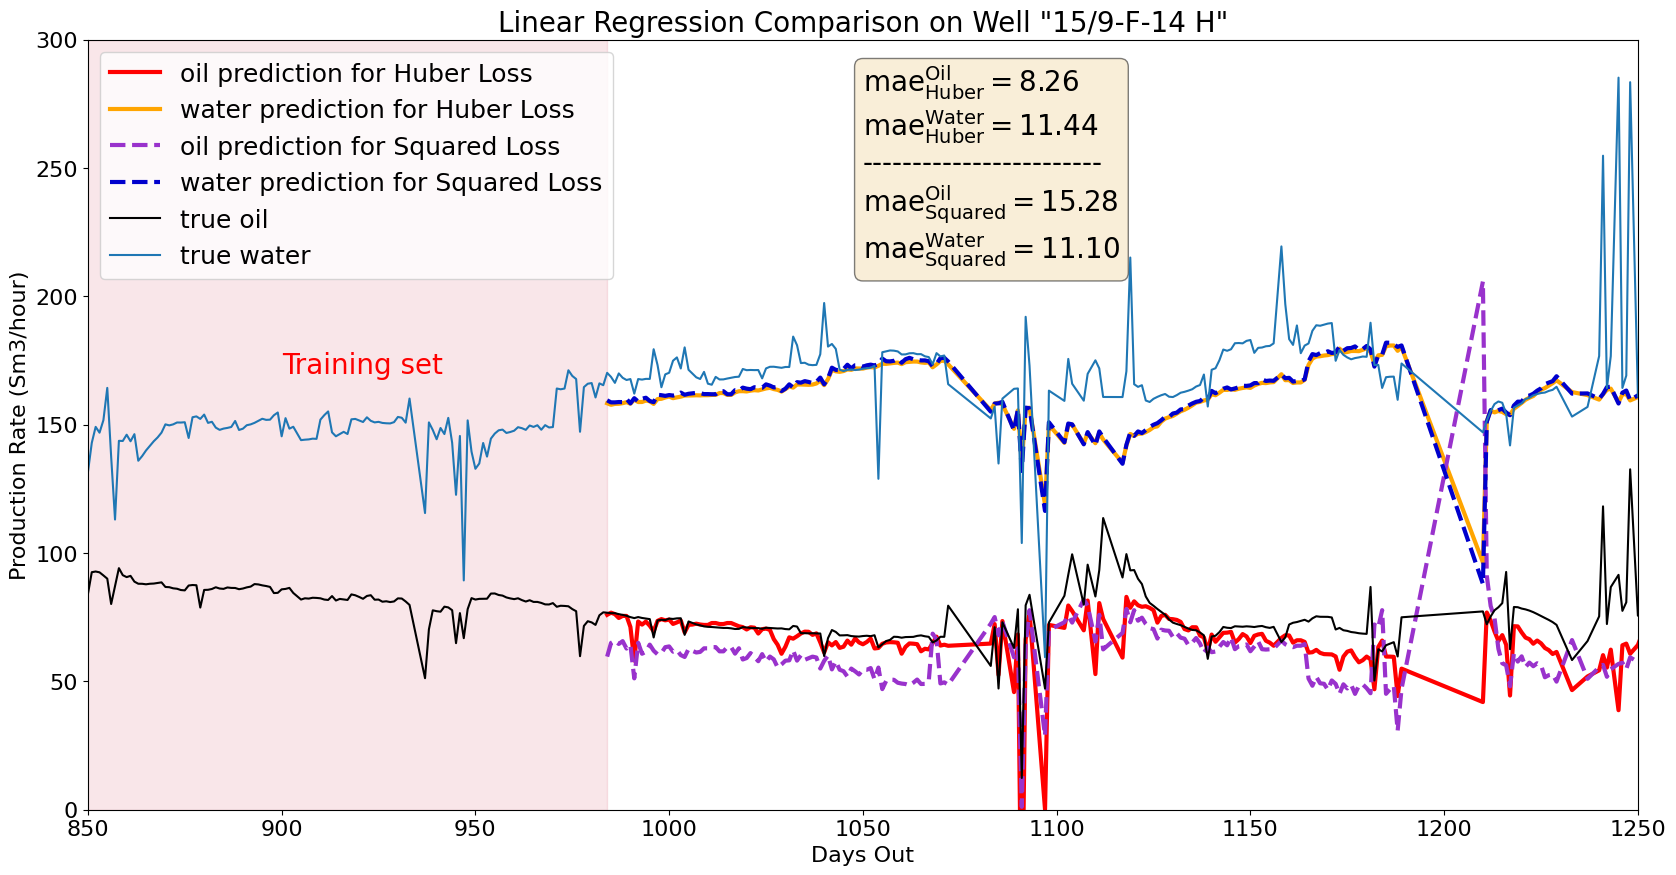

In [470]:
fig, ax = plt.subplots(figsize=(20,10)) 

oil_mae_huber, water_mae_huber, y_pred_water_huber = evalModelsSep(ax, huberOil, huberWater, 
                                               X_train, X_test, y_train, 
                                               y_test, scalerX, scalerY, "Huber Loss",
                                               linestyle="solid", colors = ("red","orange"),
                                               is_last=False)
oil_mae_linear, water_mae_linear, y_pred_water_reg = evalModelsSep(ax, linearRegOil, linearRegWater, 
                                                 X_train, X_test, y_train, 
                                                 y_test, scalerX, scalerY, "Squared Loss",
                                                 linestyle="dashed",colors = ("darkorchid","mediumblue"), 
                                                 is_last=True)

textstr = '\n'.join((
    r'$\mathrm{mae_{Huber}^{Oil}}=%.2f$' % (oil_mae_huber, ),
    r'$\mathrm{mae_{Huber}^{Water}}=%.2f$' % (water_mae_huber, ),
    "------------------------",
    r'$\mathrm{mae_{Squared}^{Oil}}=%.2f$' % (oil_mae_linear, ),
    r'$\mathrm{mae_{Squared}^{Water}}=%.2f$' % (water_mae_linear, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.5, 0.97, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.show()

In [490]:
fig.savefig(\
        "../../Explainer/images/production_prediction.png",\
            bbox_inches='tight')